# Player Detection with YOLOv8

**SC549: Neural Networks - Programming Assignment 03**

In this notebook works on below points
1. Load a pre-trained YOLOv8 model
2. Detect players in video frames
3. Visualize detection results
4. Process entire videos
5. Evaluate detection performance



## 1. Import Libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch

# YOLOv8
from ultralytics import YOLO

# Check PyTorch and CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

print("Libraries imported successfully!")

PyTorch version: 2.10.0+cpu
CUDA available: False

Using device: cpu
✅ Libraries imported successfully!


## 2. Setup Paths

In [ ]:
# Directories
PROJECT_ROOT = Path('../')
DATA_DIR = PROJECT_ROOT / 'data'
VIDEOS_DIR = DATA_DIR / 'videos'
FRAMES_DIR = DATA_DIR / 'frames'
OUTPUTS_DIR = PROJECT_ROOT / 'outputs'
MODELS_DIR = PROJECT_ROOT / 'models'

# Create output directories
(OUTPUTS_DIR / 'videos').mkdir(parents=True, exist_ok=True)
(OUTPUTS_DIR / 'screenshots').mkdir(parents=True, exist_ok=True)
(OUTPUTS_DIR / 'metrics').mkdir(parents=True, exist_ok=True)

# Find video files
video_files = list(VIDEOS_DIR.glob('*.mp4')) + list(VIDEOS_DIR.glob('*.avi'))
print(f"Found {len(video_files)} video(s)")

📹 Found 6 video(s)


## 3. Load YOLOv8 Model



In [ ]:
# Load pre-trained YOLOv8 model
print("📥 Loading YOLOv8 model...")
model = YOLO('yolov8s.pt')  # 's' = small model

# Move model to device (GPU or CPU)
model.to(device)

print(f" Model loaded on {device}")
print(f"\nModel info:")
print(f"  - Architecture: YOLOv8s")
print(f"  - Parameters: ~11.2M")
print(f"  - Pre-trained on: COCO dataset (80 classes)")
print(f"  - Person class ID: 0")

📥 Loading YOLOv8 model...
✅ Model loaded on cpu

Model info:
  - Architecture: YOLOv8s
  - Parameters: ~11.2M
  - Pre-trained on: COCO dataset (80 classes)
  - Person class ID: 0


## 4. Test Detection on a Single Frame

Test the model on one frame to see how it works.

🖼️  Testing on frame from: input_video_1.mp4
   Frame shape: (1080, 1920, 3)

🔍 Running detection...
✅ Detected 16 player(s)
   Player 1: Confidence=0.79, Box=[440, 453, 539, 563]
   Player 2: Confidence=0.76, Box=[601, 391, 647, 501]
   Player 3: Confidence=0.76, Box=[1588, 456, 1652, 561]
   Player 4: Confidence=0.75, Box=[1856, 558, 1912, 675]
   Player 5: Confidence=0.72, Box=[603, 533, 655, 632]
   Player 6: Confidence=0.69, Box=[954, 328, 1003, 424]
   Player 7: Confidence=0.68, Box=[1331, 334, 1393, 429]
   Player 8: Confidence=0.67, Box=[1250, 787, 1347, 932]
   Player 9: Confidence=0.67, Box=[1017, 477, 1071, 591]
   Player 10: Confidence=0.66, Box=[1108, 299, 1155, 400]
   Player 11: Confidence=0.62, Box=[1326, 462, 1391, 567]
   Player 12: Confidence=0.59, Box=[1168, 428, 1228, 572]
   Player 13: Confidence=0.59, Box=[1259, 254, 1303, 335]
   Player 14: Confidence=0.46, Box=[1060, 421, 1102, 515]
   Player 15: Confidence=0.44, Box=[1172, 463, 1228, 564]
   Player 16: Confide

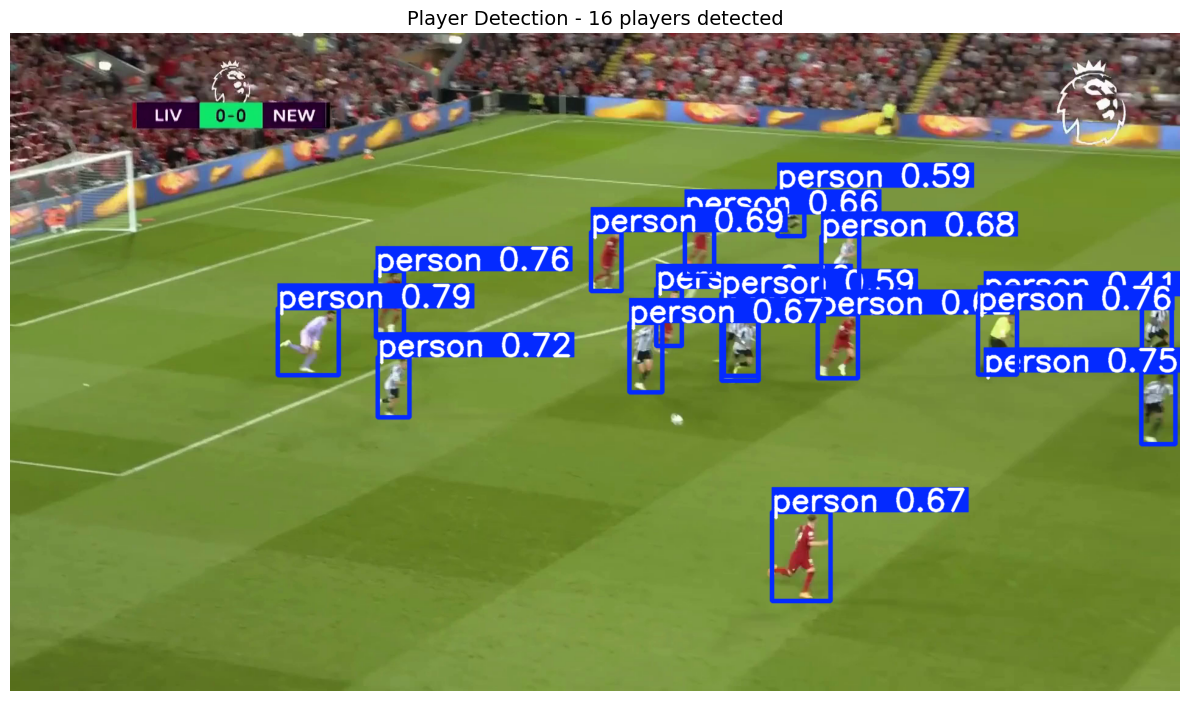


💾 Saved: ..\outputs\screenshots\detection_test.png


In [ ]:
def detect_players(image, model, conf_threshold=0.25):
    """
    Detect players (persons) in an image.
    
    Args:
        image: numpy array (BGR format from OpenCV)
        model: YOLOv8 model
        conf_threshold: Confidence threshold for detections
    
    Returns:
        results: YOLOv8 results object
    """
    # Run inference
    # classes=[0] means we only want 'person' class
    results = model(image, classes=[0], conf=conf_threshold, verbose=False)
    return results[0]  # Return first result (single image)

# Load a test frame
if len(video_files) > 0:
    # Get first video
    test_video = video_files[0]
    cap = cv2.VideoCapture(str(test_video))
    
    # Read first frame
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        print(f"Testing on frame from: {test_video.name}")
        print(f"   Frame shape: {frame.shape}")
        
        # Detect players
        print("\nRunning detection...")
        results = detect_players(frame, model, conf_threshold=0.3)
        
        # Get detection info
        boxes = results.boxes
        num_detections = len(boxes)
        
        print(f"Detected {num_detections} player(s)")
        
        # Print details of each detection
        for i, box in enumerate(boxes):
            conf = box.conf[0].item()
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            print(f"   Player {i+1}: Confidence={conf:.2f}, Box=[{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}]")
        
        # Visualize
        annotated_frame = results.plot()  # Draw boxes on image
        
        # Convert BGR to RGB for matplotlib
        annotated_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        
        # Display
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_rgb)
        plt.title(f"Player Detection - {num_detections} players detected", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        
        # Save
        save_path = OUTPUTS_DIR / 'screenshots' / 'detection_test.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n Saved: {save_path}")
    else:
        print("Could not read frame")
else:
    print(" No videos found. Please run notebook 01 first.")

## 5. Understanding Detection Results

### What information does YOLO provide?

For each detection:
1. **Bounding Box**: `[x1, y1, x2, y2]` coordinates
   - `(x1, y1)`: Top-left corner
   - `(x2, y2)`: Bottom-right corner



In [ ]:
if len(video_files) > 0 and ret:
    print("Detection Results Structure:\n")
    
    # Bounding boxes
    print("1. Bounding Boxes (xyxy format):")
    print(f"   Shape: {results.boxes.xyxy.shape}")
    print(f"   Data: {results.boxes.xyxy[:3]}...")  # Show first 3
    
    # Confidence scores
    print("\n2. Confidence Scores:")
    print(f"   Shape: {results.boxes.conf.shape}")
    print(f"   Data: {results.boxes.conf}")
    
    # Class IDs
    print("\n3. Class IDs:")
    print(f"   Shape: {results.boxes.cls.shape}")
    print(f"   Data: {results.boxes.cls}")
    print("   (All should be 0 for 'person' class)")
    
    # Original image shape
    print("\n4. Original Image:")
    print(f"   Shape: {results.orig_shape}")

📊 Detection Results Structure:

1. Bounding Boxes (xyxy format):
   Shape: torch.Size([16, 4])
   Data: tensor([[ 439.7321,  452.7468,  539.2524,  562.7229],
        [ 600.9481,  391.0231,  646.5249,  500.5193],
        [1588.4985,  455.7389, 1652.0054,  561.4688]])...

2. Confidence Scores:
   Shape: torch.Size([16])
   Data: tensor([0.7877, 0.7649, 0.7587, 0.7530, 0.7242, 0.6868, 0.6840, 0.6696, 0.6662, 0.6612, 0.6198, 0.5928, 0.5866, 0.4631, 0.4395, 0.4140])

3. Class IDs:
   Shape: torch.Size([16])
   Data: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
   (All should be 0 for 'person' class)

4. Original Image:
   Shape: (1080, 1920)


## 6. Process Complete Video

Process an entire video and save the output.

In [ ]:
def process_video_with_detection(video_path, model, output_path, conf_threshold=0.3):
    """
    Process a video and annotate with player detections.
    
    Args:
        video_path: Path to input video
        model: YOLOv8 model
        output_path: Path to save output video
        conf_threshold: Detection confidence threshold
    
    Returns:
        dict: Statistics (total frames, detections, etc.)
    """
    # Open video
    cap = cv2.VideoCapture(str(video_path))
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    print(f"Processing: {video_path.name}")
    print(f"  Resolution: {width}x{height}")
    print(f"  FPS: {fps}")
    print(f"  Total frames: {total_frames}")
    
    # Statistics
    stats = {
        'total_frames': total_frames,
        'total_detections': 0,
        'avg_detections_per_frame': 0,
        'frames_with_detections': 0
    }
    
    # Process each frame
    pbar = tqdm(total=total_frames, desc="Processing frames")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Detect players
        results = detect_players(frame, model, conf_threshold)
        
        # Update statistics
        num_detections = len(results.boxes)
        stats['total_detections'] += num_detections
        if num_detections > 0:
            stats['frames_with_detections'] += 1
        
        # Annotate frame
        annotated = results.plot()
        
        # Write frame
        out.write(annotated)
        pbar.update(1)
    
    # Cleanup
    cap.release()
    out.release()
    pbar.close()
    
    # Calculate averages
    stats['avg_detections_per_frame'] = stats['total_detections'] / stats['total_frames']
    
    print(f"\n Processing complete!")
    print(f"   Total detections: {stats['total_detections']}")
    print(f"   Avg per frame: {stats['avg_detections_per_frame']:.2f}")
    print(f"   Frames with detections: {stats['frames_with_detections']}/{stats['total_frames']}")
    print(f"   Saved to: {output_path}\n")
    
    return stats

# Process all videos
if len(video_files) > 0:
    print("Processing all videos with player detection...\n")
    
    all_stats = {}
    
    for video_path in video_files:
        output_path = OUTPUTS_DIR / 'videos' / f"detected_{video_path.name}"
        stats = process_video_with_detection(video_path, model, output_path, conf_threshold=0.3)
        all_stats[video_path.name] = stats
    
    print("\n All videos processed!")
    print(f" Output videos: {OUTPUTS_DIR / 'videos'}")
else:
    print(" No videos found")

🎬 Processing all videos with player detection...

Processing: input_video_1.mp4
  Resolution: 1920x1080
  FPS: 30
  Total frames: 297


Processing frames: 100%|███████████████████████████████████████████████████| 297/297 [02:32<00:00,  1.95it/s]



✅ Processing complete!
   Total detections: 5066
   Avg per frame: 17.06
   Frames with detections: 297/297
   Saved to: ..\outputs\videos\detected_input_video_1.mp4

Processing: input_video_2.mp4
  Resolution: 848x480
  FPS: 24
  Total frames: 240


Processing frames: 100%|███████████████████████████████████████████████████| 240/240 [01:50<00:00,  2.17it/s]



✅ Processing complete!
   Total detections: 3467
   Avg per frame: 14.45
   Frames with detections: 240/240
   Saved to: ..\outputs\videos\detected_input_video_2.mp4

Processing: input_video_3.mp4
  Resolution: 848x480
  FPS: 60
  Total frames: 644


Processing frames: 100%|███████████████████████████████████████████████████| 644/644 [04:51<00:00,  2.21it/s]



✅ Processing complete!
   Total detections: 3524
   Avg per frame: 5.47
   Frames with detections: 636/644
   Saved to: ..\outputs\videos\detected_input_video_3.mp4

Processing: input_video_4.mp4
  Resolution: 1920x1080
  FPS: 25
  Total frames: 250


Processing frames: 100%|███████████████████████████████████████████████████| 250/250 [02:11<00:00,  1.91it/s]



✅ Processing complete!
   Total detections: 4035
   Avg per frame: 16.14
   Frames with detections: 250/250
   Saved to: ..\outputs\videos\detected_input_video_4.mp4

Processing: input_video_5.mp4
  Resolution: 1920x1080
  FPS: 25
  Total frames: 253


Processing frames: 100%|███████████████████████████████████████████████████| 253/253 [02:49<00:00,  1.49it/s]



✅ Processing complete!
   Total detections: 4583
   Avg per frame: 18.11
   Frames with detections: 253/253
   Saved to: ..\outputs\videos\detected_input_video_5.mp4

Processing: input_video_6.mp4
  Resolution: 1280x720
  FPS: 25
  Total frames: 240


Processing frames: 100%|███████████████████████████████████████████████████| 240/240 [02:34<00:00,  1.56it/s]


✅ Processing complete!
   Total detections: 3804
   Avg per frame: 15.85
   Frames with detections: 240/240
   Saved to: ..\outputs\videos\detected_input_video_6.mp4


✅ All videos processed!
📁 Output videos: ..\outputs\videos


## 7. Detection Performance Analysis

Analyze the detection results across all videos.


📊 Detection Summary:

            Video  Total Frames  Total Detections Avg Detections/Frame  Frames with Players
input_video_1.mp4           297              5066                17.06                  297
input_video_2.mp4           240              3467                14.45                  240
input_video_3.mp4           644              3524                 5.47                  636
input_video_4.mp4           250              4035                16.14                  250
input_video_5.mp4           253              4583                18.11                  253
input_video_6.mp4           240              3804                15.85                  240


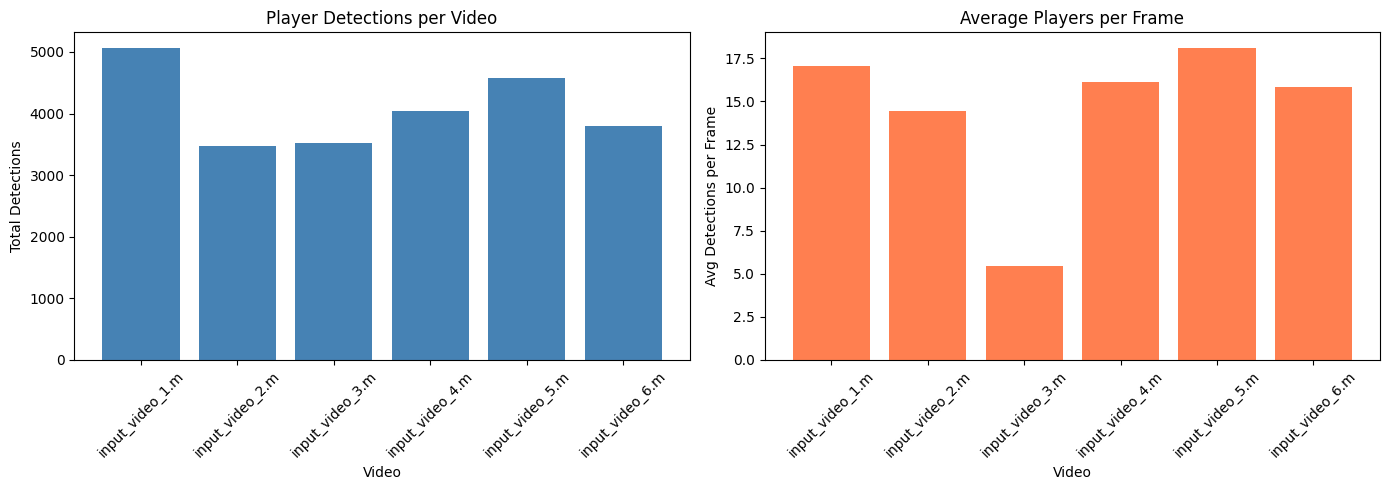


💾 Saved chart: ..\outputs\metrics\detection_stats.png


In [ ]:
if len(video_files) > 0:
    import pandas as pd
    
    # Create summary DataFrame
    summary_data = []
    for video_name, stats in all_stats.items():
        summary_data.append({
            'Video': video_name,
            'Total Frames': stats['total_frames'],
            'Total Detections': stats['total_detections'],
            'Avg Detections/Frame': f"{stats['avg_detections_per_frame']:.2f}",
            'Frames with Players': stats['frames_with_detections']
        })
    
    df_summary = pd.DataFrame(summary_data)
    
    print("\n Detection Summary:\n")
    print(df_summary.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Chart 1: Total detections per video
    videos = [s['Video'][:15] for s in summary_data]  # Truncate names
    detections = [s['Total Detections'] for s in summary_data]
    
    axes[0].bar(videos, detections, color='steelblue')
    axes[0].set_xlabel('Video')
    axes[0].set_ylabel('Total Detections')
    axes[0].set_title('Player Detections per Video')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Chart 2: Average detections per frame
    avg_detections = [float(s['Avg Detections/Frame']) for s in summary_data]
    
    axes[1].bar(videos, avg_detections, color='coral')
    axes[1].set_xlabel('Video')
    axes[1].set_ylabel('Avg Detections per Frame')
    axes[1].set_title('Average Players per Frame')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Save
    save_path = OUTPUTS_DIR / 'metrics' / 'detection_stats.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Saved chart: {save_path}")

## 8. Confidence Threshold Analysis

Different confidence thresholds affect detection.

🔍 Testing different confidence thresholds...

  Threshold 0.10: 22 detections
  Threshold 0.25: 16 detections
  Threshold 0.50: 13 detections
  Threshold 0.70: 5 detections
  Threshold 0.90: 0 detections


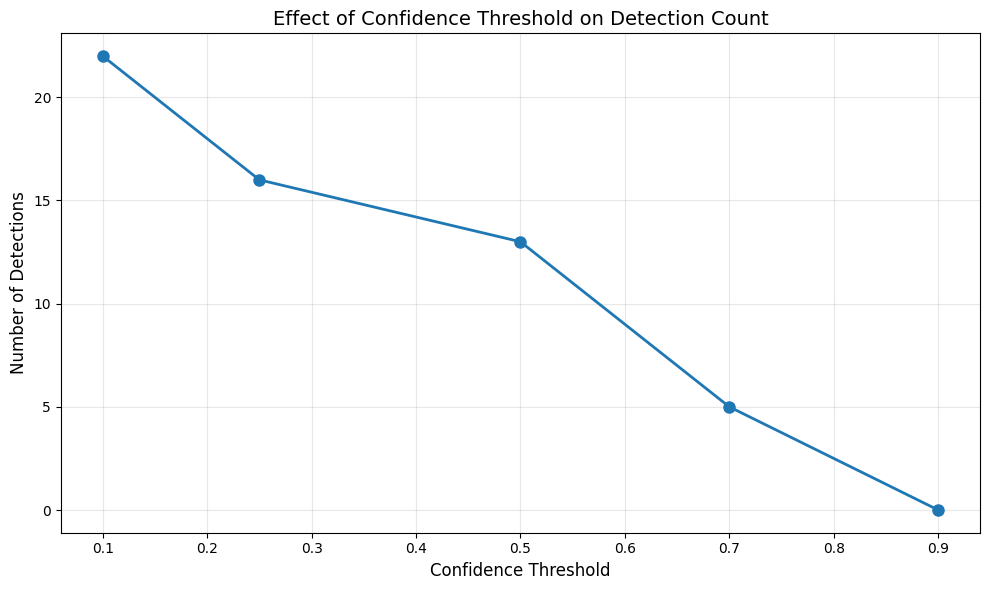


💾 Saved: ..\outputs\metrics\confidence_threshold_analysis.png

💡 Lower threshold = more detections (but may include false positives)
   Higher threshold = fewer detections (but higher confidence)


In [ ]:
if len(video_files) > 0:
    # Test different thresholds on first video
    test_video = video_files[0]
    cap = cv2.VideoCapture(str(test_video))
    ret, test_frame = cap.read()
    cap.release()
    
    if ret:
        thresholds = [0.1, 0.25, 0.5, 0.7, 0.9]
        detection_counts = []
        
        print(" Testing different confidence thresholds...\n")
        
        for thresh in thresholds:
            results = detect_players(test_frame, model, conf_threshold=thresh)
            count = len(results.boxes)
            detection_counts.append(count)
            print(f"  Threshold {thresh:.2f}: {count} detections")
        
        # Visualize
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, detection_counts, marker='o', linewidth=2, markersize=8)
        plt.xlabel('Confidence Threshold', fontsize=12)
        plt.ylabel('Number of Detections', fontsize=12)
        plt.title('Effect of Confidence Threshold on Detection Count', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save
        save_path = OUTPUTS_DIR / 'metrics' / 'confidence_threshold_analysis.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n Saved: {save_path}")
        print("\n Lower threshold = more detections (but may include false positives)")
        print("   Higher threshold = fewer detections (but higher confidence)")

## 9. Create Comparison Screenshot

Show before/after detection on multiple frames.

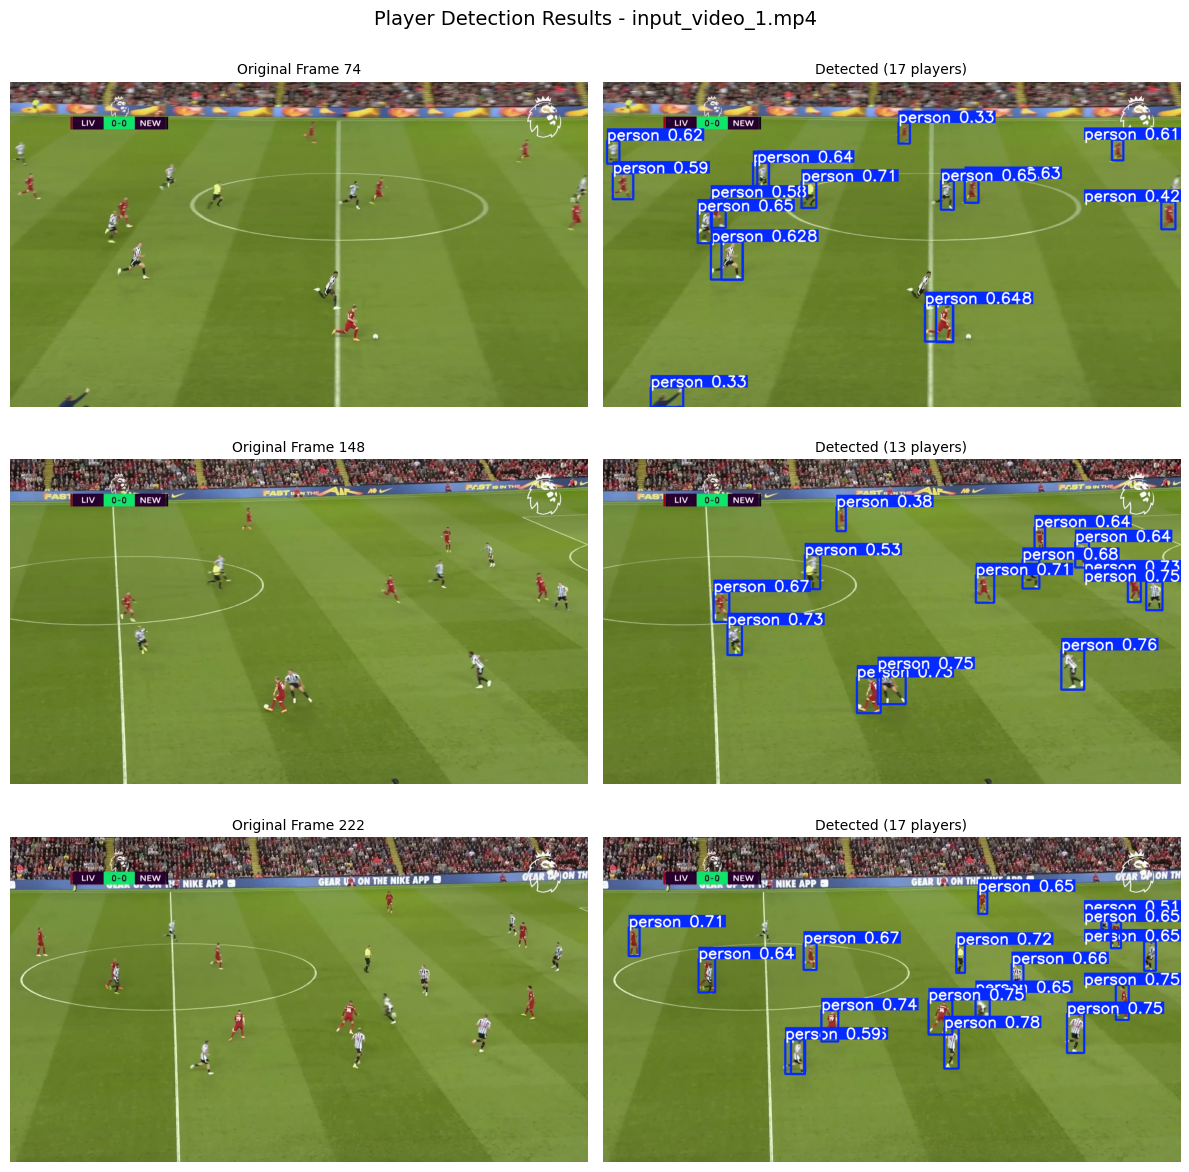

💾 Saved: ..\outputs\screenshots\detection_comparison.png


In [ ]:
if len(video_files) > 0:
    # Select first video
    video_path = video_files[0]
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Select 3 frames evenly spaced
    frame_indices = [total_frames // 4, total_frames // 2, 3 * total_frames // 4]
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    
    for row, frame_idx in enumerate(frame_indices):
        # Seek to frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if ret:
            # Original frame
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[row, 0].imshow(frame_rgb)
            axes[row, 0].set_title(f"Original Frame {frame_idx}", fontsize=10)
            axes[row, 0].axis('off')
            
            # Detected frame
            results = detect_players(frame, model, conf_threshold=0.3)
            annotated = results.plot()
            annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
            
            num_players = len(results.boxes)
            axes[row, 1].imshow(annotated_rgb)
            axes[row, 1].set_title(f"Detected ({num_players} players)", fontsize=10)
            axes[row, 1].axis('off')
    
    cap.release()
    
    plt.suptitle(f"Player Detection Results - {video_path.name}", fontsize=14, y=0.995)
    plt.tight_layout()
    
    # Save
    save_path = OUTPUTS_DIR / 'screenshots' / 'detection_comparison.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: {save_path}")